# SIMPLE KRIGING IN PYTHON - 1D Application for a Single Point

### Note:

*This Notebook is based on an original Post from Connor Johnson, the original post is found here:
http://connor-johnson.com/2014/03/20/simple-kriging-in-python/. It has been transferred to a Jupyter Notebook to make it more interactive.*

*Changes being made:*
+ *using a common variogram function*
+ *calculation of variance map* 
+ *some code structure*

*The example data is modified to represent a quasi-1D distribution (along the x-axis), to improve comprehensibility. Visualisation has been changed to consider this, and puts an additional focus on the uncertainty of the prediction*

*The Kriging Method has been further broken up into its elementary steps to allow better understanding and the facilitates further developments. Accordingly, this Notebook only estimates and visualises a single point.

# Original Post

In this post I will work through an example of Simple Kriging. Kriging is a set of techniques for interpolation. It differs from other interpolation techniques in that it sacrifices smoothness for the integrity of sampled points. Most interpolation techniques will over or undershoot the value of the function at sampled locations, but kriging honors those measurements and keeps them fixed. In future posts I would like to cover other types of kriging, other semivariaogram models, and colocated co-kriging. Until then, I’m keeping relatively up to date code at my GitHub project, geostatsmodels. (https://github.com/cjohnson318/geostatsmodels)

In [1]:
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [16 / 1.5, 10 / 1.5]   # inch / cm = 2.54
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
# plt.rcParams['savefig.frameon'] = False

## Loading the Data

The data used in this exercise is in a zip file at this site. (Click on Geostatistics Resources.) I have adapted my material from the Kriging document on the same site. My approach will focus more on programming. First we will import some modules and then load the data and parse it,

In [2]:
zraw = open( 'WGTutorial/ZoneA.dat','r' ).readlines()
zraw = [ i.strip().split() for i in zraw[10:] ]
zraw = np.array( zraw, dtype=np.float )
zraw = DataFrame( zraw, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )

### Choose a sub-set and reduce to Quasi-1D

For this exercise, we need to reduce the data, and only choose values within a certain intervall for y, and create a quasi-1D Dataset by zeroing the y-coordinate. This is necessary as the method may fail during matrix inversion if there are two points with (near) equal x-coordinates, leading to a singular matrix.

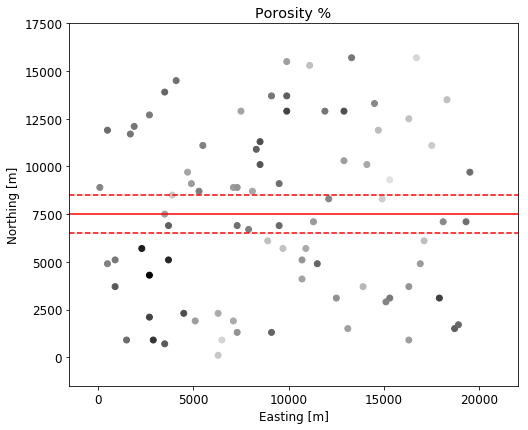

In [3]:
# choose the data subset from a y-intervall
ymean = 7500
yinterval = 2000

z = zraw  # create copy of full data set

# show the intervall before reducing the data
fig, ax = subplots()
ax.scatter( z.x, z.y, c=z.por, cmap='gray' )
ax.plot((-1500,22000),(ymean - yinterval / 2, ymean - yinterval / 2), "r--")
ax.plot((-1500,22000),(ymean + yinterval / 2, ymean + yinterval / 2), "r--")
ax.plot((-1500,22000),(ymean, ymean), "r-")
ax.set_aspect(1)
xlim(-1500,22000)
ylim(-1500,17500)
xlabel('Easting [m]')
ylabel('Northing [m]')
title('Porosity %') ;

plt.show()

z = z.loc[z.y > ymean - yinterval / 2]
z = z.loc[z.y < ymean + yinterval / 2]


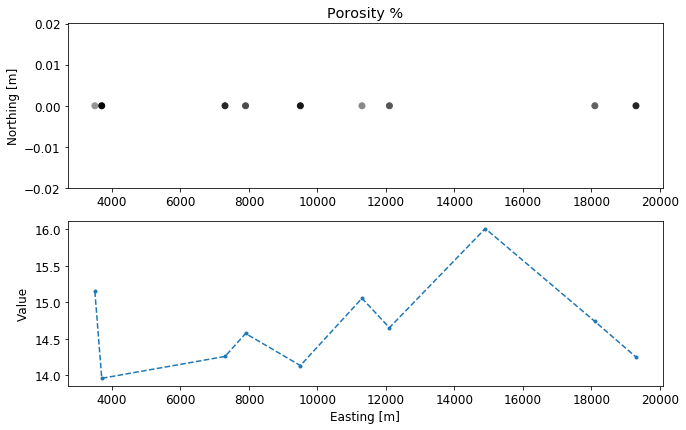

P =
[[  3.50000000e+03   0.00000000e+00   1.51486000e+01]
 [  3.70000000e+03   0.00000000e+00   1.39584000e+01]
 [  7.30000000e+03   0.00000000e+00   1.42580000e+01]
 [  7.90000000e+03   0.00000000e+00   1.45724000e+01]
 [  9.50000000e+03   0.00000000e+00   1.41333000e+01]
 [  1.13000000e+04   0.00000000e+00   1.50547000e+01]
 [  1.21000000e+04   0.00000000e+00   1.46515000e+01]
 [  1.49000000e+04   0.00000000e+00   1.60095000e+01]
 [  1.81000000e+04   0.00000000e+00   1.47374000e+01]
 [  1.93000000e+04   0.00000000e+00   1.42498000e+01]]


In [4]:
# reduce to quasi 1-D by assigning zero as y-coordinates for all samples,
# and sort the array by x-coordinate for better plottability.

z.y = 0.
z = z.sort_values(by="x")

plt.subplot(211)
plt.scatter( z.x, z.y, c=z.por, cmap='gray' )
ylabel('Northing [m]')
title('Porosity %') ;

plt.subplot(212)
plt.plot(z.x, z.por, ".--")
ylabel('Value')
xlabel('Easting [m]')
plt.show()

# part of our data set recording porosity
P = np.array( z[['x','y','por']] )
print("P =")
print(P)


## The Semivariogram

The semivariogram encodes data about spatial variance over the region at a given distance or lag. We generally expect data points that are close together spatially to share other characteristics, and we expect points that are separated by greater distances to have lesser correlation. The semivariogram allows us to model the similarity points in a field as a function of distance. The semivariogram is given by,

$$\begin{equation*} \hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i} - z_{j} )^{2} \end{equation*}$$ (Equation 1)

Here, h is distance specified by the user, and z_{i} and z_{j} are two points that are separated spatially by h. The N(h) term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance h. As an aside, contrast this with the formulation for variance,

$$\begin{equation*} s = \dfrac{1}{N-1} \displaystyle \sum_{k=1}^{N} (z_{k} - \hat{\mu} )^{2} \end{equation*}$$ (Equation 2)

Here, $N$ is the number of data points, $\hat{\mu}$ is the sample mean, and $z_{k}$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance h. We can write some functions to calculate the semivariogram at one lag, and then at multiple lags as follows.

In [5]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

The C() function is the covariance function, and will be used later. Let us now calculate and plot the semivariogram,

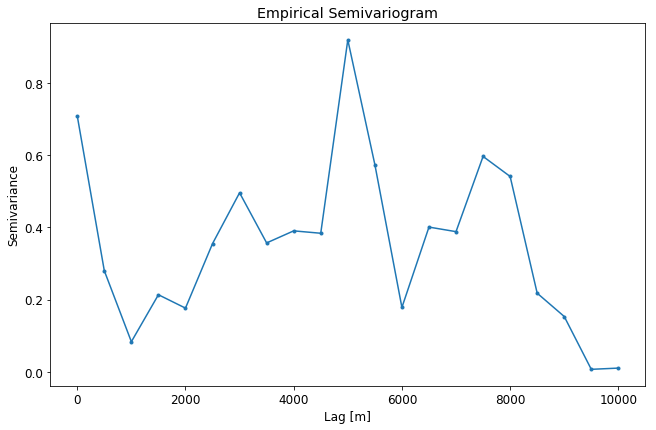

In [6]:
# bandwidth, plus or minus 250 meters
bw = 500
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,10500,bw)
sv = SV( P, hs, bw )
plot( sv[0], sv[1], '.-' )
xlabel('Lag [m]')
ylabel('Semivariance')
title('Empirical Semivariogram') ;
savefig('sample_semivariogram.png', fmt='png', dpi=200)

Modeling
Now that we’ve calculated the semivariogram, we will need to fit a model to the data. There are three popular models, the spherical, exponential, and the Gaussian. Here, we’ll implement the spherical model. First, we will present a function named opt() for determining the optimal value a for the spherical model.

In [7]:
def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]

The opt() function finds the optimal parameter for fitting a spherical model to the semivariogram data. The spherical model is given by the function spherical(). On the last line we see that spherical() returns itself in a map() function, which seems odd. The idea is that the input h can be a single float value, or list or NumPy array of floats. If h is a single value, then line 9 is called. If h is a list or an array (an iterable) then line 17 is called, which applies line 9 to each value of h.

In [8]:
def spherical( h, a, C0 ):
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

Next, cvmodel() fits a model to the semivariogram data and returns a covariance method named covfct().

In [9]:
def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=param: C0 - model( h, a, C0 )
    return covfct

At this point we’ll plot our model and see if it represents our data well.

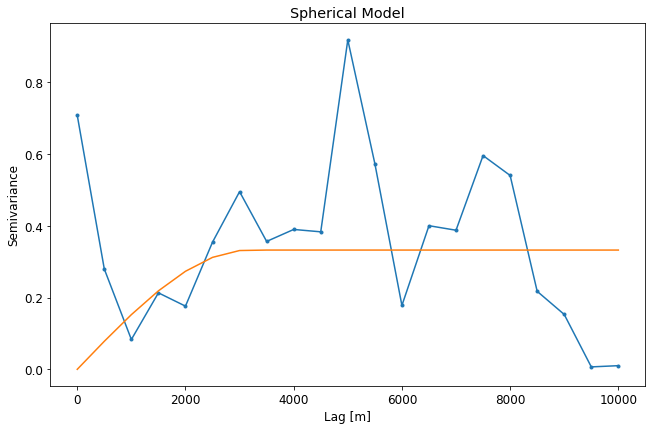

In [10]:
sp = cvmodel( P, model=spherical, hs=np.arange(0,10500,500), bw=500 )
C0 = C( P, hs[0], bw )
plot( sv[0], sv[1], '.-' )
plot( sv[0], C0 - sp( sv[0] ) ) ;
title('Spherical Model')
ylabel('Semivariance')
xlabel('Lag [m]')
savefig('semivariogram_model.png',fmt='png',dpi=200)


## Simple Kriging


Now that we have a model for the semivariogram, we can write a function to perform the kriging. The fundamental relationship is a matrix equation,

$$\begin{equation*} K \lambda = k \Rightarrow \lambda = K^{-1} k \end{equation*} $$ 

Here, $K$ is a matrix of covariances of sampled data points, calculated using the spherical model, $\lambda$ is a vector of simple kriging weights, and $k$ is the vector of covariances between the data points and an unsampled point. Our kriging function takes the data set $P$, the model, the distances hs, the bandwidth bw, the coordinates of the unsampled point u, and the number of surrounding points N to use in the calculation.

### Choosing the parameters

In [11]:
# h, k, K, weights = krige( P, sp, (dy*j,dx*i), len(z) / 2 )       
# PARAMETER DEFINITION
#           (P)     data set [y,x,value]
#           (model) modeling function
#                    - spherical
#                    - exponential
#                    - gaussian
#           (u)     unsampled point
#           (N)     number of neighboring
#                   points to consider

# P - Data set already defined
covfct = sp  # covariance function
u = (6000, 0)  # (x,y) - coordinates of unsampled points
N = 5  # number of neighbors to consider
assert N < len(P) + 1, "Number of Neighbors greater than number of data points"

### Performing the Kriging Process for a single point

In [12]:
# the mean of the variable
mu = np.mean( P[:,2] )
print("mu = " + str(mu))

mu = 14.67736


The distance between the unsampled point $u$ and each data point in $P$ is calculated, creating a vector $d$ of size 1xM, where M is the number of data points.

This vector becomes an additional column to the matric $P$, which allows to sort the rows of $P$ by their distance to the data point, and only selecting to closest N neighbors.. 

In [13]:
# distance between u and each data point in P (1xN vector)
d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )  # 2D 
print("d = "+str(d))

d = [  2500.   2300.   1300.   1900.   3500.   5300.   6100.   8900.  12100.
  13300.]


In [14]:
# add these distances to P
P = np.vstack(( P.T, d )).T
# sort P by these distances
# take the first N of them
P = P[d.argsort()[:N]]
print("P = \n" + str(P))

P = 
[[ 7300.         0.        14.258   1300.    ]
 [ 7900.         0.        14.5724  1900.    ]
 [ 3700.         0.        13.9584  2300.    ]
 [ 3500.         0.        15.1486  2500.    ]
 [ 9500.         0.        14.1333  3500.    ]]


For each of the remaining points, the expected covariance between the point and the unsampled point $u$ is calculated based on its distance by the convariance function

$$k = cov(d)$$

In [15]:
# apply the covariance model to the distances
k = covfct( P[:,3] )
# cast as a matrix
k = np.matrix( k ).T
print("k =\n" + str(k))

k =
[[ 0.13907508]
 [ 0.06893667]
 [ 0.03374271]
 [ 0.02037221]
 [ 0.        ]]


To create the covariance matrix $K$ with the covariances of all sampled points, the same function is being used:

$$K = [cov(d_{ij})]$$

with $d_{ij}$ being the Euclidian distance between points $i$ and $j$.

In [16]:
# form a matrix of distances between existing data points
K = squareform( pdist( P[:,:2] ) )
# apply the covariance model to these distances
K = covfct( K.ravel() )
# re-cast as a NumPy array -- thanks M.L.
K = np.array( K )
# reshape into an array
K = K.reshape(N,N)
# cast as a matrix
K = np.matrix( K )
print("K =\n"+str(K))

K =
[[ 0.33259149  0.23908128  0.          0.          0.04153189]
 [ 0.23908128  0.33259149  0.          0.          0.10173493]
 [ 0.          0.          0.33259149  0.30108498  0.        ]
 [ 0.          0.          0.30108498  0.33259149  0.        ]
 [ 0.04153189  0.10173493  0.          0.          0.33259149]]


this allows calculating the Kriging weights $\lambda$ as defined previously

$$\lambda = K^{-1} k$$ 

In [17]:
# calculate the kriging weights
weights = np.linalg.inv( K ) * k
weights = np.array( weights )
print("weights =\n"+str(weights))

weights =
[[ 0.55464154]
 [-0.18781688]
 [ 0.25488551]
 [-0.16948716]
 [-0.01180961]]


$$\epsilon = P[:,2] - \mu$$

In [18]:
# calculate the residuals
residuals = P[:,2] - mu
print("residuals = "+str(residuals))

residuals = [-0.41936 -0.10496 -0.71896  0.47124 -0.54406]


$$e(u) =\lambda^T \cdot \epsilon + \mu $$

In [19]:
# calculate the estimation
estimation = np.dot( weights.T, residuals ) + mu
print("estimation = "+str(estimation))

estimation = [ 14.2077823]


$$\sigma^2 = C_0 - \lambda^T \cdot k$$

In [20]:
variance = C0 - np.dot( weights.T, k )
print("variance = "+str(variance))

variance = [[ 0.26325444]]


### Visualize the Result

The plot below shows the estimate (error bar equals +/- 1 standard deviation) and the sampled points. For the {{N}} samples closest to the estimate the kriging weights are shown.  

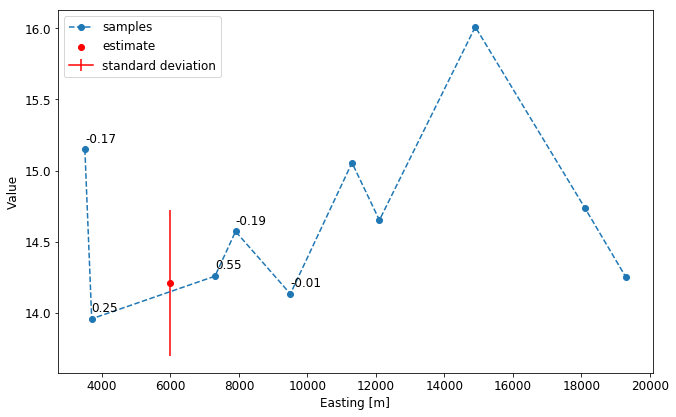

In [21]:
plt.plot(z.x, z.por, 
         "o--", label="samples")
plt.scatter((u[0]), (estimation), 
            c="red", label="estimate")
plt.errorbar((u[0]), (estimation), yerr = sqrt(float(variance)), 
             fmt="r", label="standard deviation")

offset = 0.05
for i in range(len(weights)):
    plt.text(P[i,0]+offset, 
             P[i,2]+offset, 
             "{:.2f}".format(float(weights[i])))

ylabel('Value')
xlabel('Easting [m]')
plt.legend()
plt.show()